In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
import itertools
import time

In [156]:
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
    return pred_values

In [157]:
# Create train and test Dataset (70% train and 30% test)
# IMPORTANT: EACH TIME THIS CODE BLOCK IS LOADED, THE TRAIN AND TEST DATASETS WILL CHANGE
#train = df.sample(int(np.floor(df.shape[0] * 0.7)))
#test = df.drop(train.index)

In [158]:
heart_dataset = pd.read_csv('heart_2020_cleaned.csv')

In [159]:
heart_dataset.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Binning BMI

In [160]:
df = heart_dataset.copy()

In [161]:
def reformat(data):
    replacement_values = {"Yes": 1, "No": 0, "Yes (during pregnancy)": 1, "No, borderline diabetes": 0, "Male": 0, "Female": 1}
    replacement_age = {"18-24": 0, "25-29": 1, "30-34": 2, "35-39": 3, "40-44": 4, "45-49": 5, "50-54": 6, "55-59": 7, "60-64": 8, "65-69": 9, "70-74": 10, "75-79": 11, "80 or older": 12}
    replacement_race = {"White": 0, "Black": 1, "Asian": 2, "American Indian/Alaskan Native": 3, "Hispanic": 4, "Other": 5}
    replacement_genhealth = {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}
    #replacement_bmi_cut = {'(11.937, 19.55]': 0, '(19.55, 27.08]': 1, '(27.08, 34.61]': 2, '(34.61, 42.14]': 3, '(42.14, 49.67]': 4, '(49.67, 57.2]': 5, '(57.2, 64.73]': 6, '(64.73, 72.26]': 7, '(72.26, 79.79]': 8, '(79.79, 87.32]': 9, '(87.32, 94.85]': 10}
    data.replace(replacement_values, inplace = True)
    data.replace(replacement_age, inplace = True)
    data.replace(replacement_race, inplace = True)
    data.replace(replacement_genhealth, inplace = True)
    #data.replace(replacement_bmi_cut, inplace = True)
reformat(df)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,1,7,0,1,1,3,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,12,0,0,1,3,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,0,9,0,1,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,11,0,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,1,4,0,0,1,3,8.0,0,0,0


In [162]:
bmi_bins_cut = pd.cut(df['BMI'],11,retbins=True)
df['bmi_binned_cut'] = bmi_bins_cut[0]
bmi_binned_data_cut = df.groupby('bmi_binned_cut')['HeartDisease'].agg([('y_percentage','mean'),('nobs','count')]).reset_index(drop=False)
bmi_binned_data_cut

,bmi_binned_cut,y_percentage,nobs
0,"(11.937, 19.55]",0.067918,11131
1,"(19.55, 27.08]",0.071459,142249
2,"(27.08, 34.61]",0.095236,121771
3,"(34.61, 42.14]",0.106982,33875
4,"(42.14, 49.67]",0.114572,8091
5,"(49.67, 57.2]",0.114712,1944
6,"(57.2, 64.73]",0.109562,502
7,"(64.73, 72.26]",0.112782,133
8,"(72.26, 79.79]",0.125000,64
9,"(79.79, 87.32]",0.120000,25


Text(0.5, 0, 'bmi_binned')

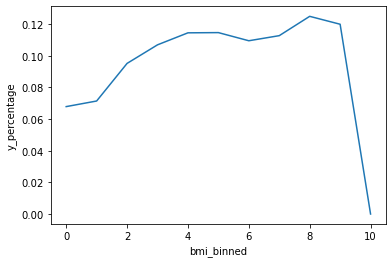

In [163]:
sns.lineplot(x = bmi_binned_data_cut.index, y= bmi_binned_data_cut['y_percentage'])
plt.xlabel('bmi_binned')

In [164]:
bmi_bins_qcut = pd.qcut(df['BMI'],11,retbins=True)
df['bmi_binned_qcut'] = bmi_bins_qcut[0]
bmi_binned_data_qcut = df.groupby('bmi_binned_qcut')['HeartDisease'].agg([('y_percentage','mean'),('nobs','count')]).reset_index(drop=False)
bmi_binned_data_qcut

,bmi_binned_qcut,y_percentage,nobs
0,"(12.019, 21.26]",0.060773,29141
1,"(21.26, 23.01]",0.062807,29360
2,"(23.01, 24.33]",0.068150,29127
3,"(24.33, 25.61]",0.078318,29559
4,"(25.61, 26.61]",0.080488,28290
5,"(26.61, 27.89]",0.088845,28983
6,"(27.89, 29.26]",0.088829,29720
7,"(29.26, 31.0]",0.098794,29030
8,"(31.0, 33.23]",0.101222,28640
9,"(33.23, 36.92]",0.104608,29099


Text(0.5, 0, 'bmi_binned')

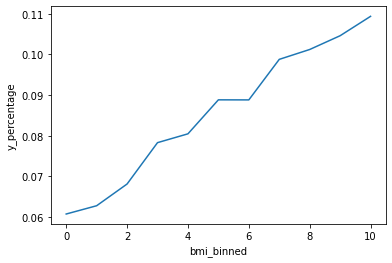

In [165]:
sns.lineplot(x = bmi_binned_data_qcut.index, y= bmi_binned_data_qcut['y_percentage'])
plt.xlabel('bmi_binned')

In [166]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,bmi_binned_cut,bmi_binned_qcut
0,0,16.60,1,0,0,3.0,30.0,0,1,7,0,1,1,3,5.0,1,0,1,"(11.937, 19.55]","(12.019, 21.26]"
1,0,20.34,0,0,1,0.0,0.0,0,1,12,0,0,1,3,7.0,0,0,0,"(19.55, 27.08]","(12.019, 21.26]"
2,0,26.58,1,0,0,20.0,30.0,0,0,9,0,1,1,1,8.0,1,0,0,"(19.55, 27.08]","(25.61, 26.61]"
3,0,24.21,0,0,0,0.0,0.0,0,1,11,0,0,0,2,6.0,0,0,1,"(19.55, 27.08]","(23.01, 24.33]"
4,0,23.71,0,0,0,28.0,0.0,1,1,4,0,0,1,3,8.0,0,0,0,"(19.55, 27.08]","(23.01, 24.33]"


### Formatting Data for Smote

In [167]:
def reformat_bmi(data):
    df['bmi_binned_cut'] = df['bmi_binned_cut'].apply(lambda x: str(x))
    df['bmi_binned_qcut'] = df['bmi_binned_qcut'].apply(lambda x: str(x))
    replacement_bmi_cut = {'(11.937, 19.55]': 0, '(19.55, 27.08]': 1, '(27.08, 34.61]': 2, '(34.61, 42.14]': 3, '(42.14, 49.67]': 4, '(49.67, 57.2]': 5, '(57.2, 64.73]': 6, '(64.73, 72.26]': 7, '(72.26, 79.79]': 8, '(79.79, 87.32]': 9, '(87.32, 94.85]': 10}
    replacement_bmi_qcut = {'(12.019, 21.26]' : 0, '(21.26, 23.01]': 1, '(23.01, 24.33]': 2, '(24.33, 25.61]': 3, '(25.61, 26.61]': 4, '(26.61, 27.89]': 5, '(27.89, 29.26]': 6, '(29.26, 31.0]': 7, '(31.0, 33.23]': 8, '(33.23, 36.92]': 9, '(36.92, 94.85]': 10}
    data.replace(replacement_bmi_cut, inplace = True)
    data.replace(replacement_bmi_qcut, inplace = True)
reformat_bmi(df)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,bmi_binned_cut,bmi_binned_qcut
0,0,16.60,1,0,0,3.0,30.0,0,1,7,0,1,1,3,5.0,1,0,1,0,0
1,0,20.34,0,0,1,0.0,0.0,0,1,12,0,0,1,3,7.0,0,0,0,1,0
2,0,26.58,1,0,0,20.0,30.0,0,0,9,0,1,1,1,8.0,1,0,0,1,4
3,0,24.21,0,0,0,0.0,0.0,0,1,11,0,0,0,2,6.0,0,0,1,1,2
4,0,23.71,0,0,0,28.0,0.0,1,1,4,0,0,1,3,8.0,0,0,0,1,2


### Creating Smote Train and Test

In [168]:
X = df[['BMI', 'Smoking', 'AlcoholDrinking', "Stroke", 'PhysicalHealth', "MentalHealth", "DiffWalking", "Sex", "AgeCategory", "Race", "Diabetic", "PhysicalActivity", "GenHealth", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer", "bmi_binned_cut", "bmi_binned_qcut"]]
y = df.HeartDisease

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [170]:
test = pd.concat([X_test, y_test], axis=1)

In [171]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
oversampled = SMOTE(random_state=0)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [172]:
train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

In [173]:
train_smote.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,bmi_binned_cut,bmi_binned_qcut,HeartDisease
0,31.63,0,0,0,0.0,0.0,0,0,4,4,0,1,4,6.0,0,0,0,2,8,0
1,27.98,1,0,0,0.0,0.0,0,0,10,0,1,1,1,8.0,0,0,0,2,6,1
2,26.58,1,0,0,0.0,0.0,0,0,5,0,0,1,4,6.0,0,0,0,1,4,0
3,33.28,1,0,0,0.0,23.0,0,1,10,0,1,1,2,8.0,0,0,0,2,9,0
4,26.57,0,0,0,0.0,0.0,0,1,0,4,0,0,3,8.0,0,0,0,1,4,0


In [174]:
### Reformating Data back to Categorical 

In [181]:
def reverse_reformat(data):
    #replacement_values = {"Yes": 1, "No": 0, "Yes (during pregnancy)": 1, "No, borderline diabetes": 0, "Male": 0, "Female": 1}
    replacement_age = {0 : "18-24", 1 : "25-29", 2 : "30-34", 3 : "35-39", 4 : "40-44", 5 : "45-49", 6 : "50-54", 7: "55-59", 8: "60-64", 9: "65-69", 10: "70-74", 11:  "75-79", 12: "80 or older"}
    replacement_race = { 0: "White", 1: "Black", 2 : "Asian", 3: "American Indian/Alaskan Native",  4: "Hispanic", 5: "Other"}
    replacement_genhealth = {0: "Poor", 1: "Fair", 2: "Good", 3: "Very good", 4: "Excellent"}
    replacement_bmi_cut = {0: '(11.937, 19.55]', 1: '(19.55, 27.08]', 2: '(27.08, 34.61]', 3: '(34.61, 42.14]', 4: '(42.14, 49.67]', 5: '(49.67, 57.2]', 6: '(57.2, 64.73]', 7: '(64.73, 72.26]', 8: '(72.26, 79.79]', 9: '(79.79, 87.32]', 10: '(87.32, 94.85]'}
    replacement_bmi_qcut = {0: '(12.019, 21.26]', 1: '(21.26, 23.01]', 2: '(23.01, 24.33]', 3: '(24.33, 25.61]', 4: '(25.61, 26.61]', 5: '(26.61, 27.89]', 6: '(27.89, 29.26]', 7: '(29.26, 31.0]', 8: '(31.0, 33.23]', 9: '(33.23, 36.92]', 10: '(36.92, 94.85]'}
    #data.replace(replacement_values, inplace = True)
    data['AgeCategory'].replace(replacement_age, inplace = True)
    data['Race'].replace(replacement_race, inplace = True)
    data['GenHealth'].replace(replacement_genhealth, inplace = True)
    data['bmi_binned_cut'].replace(replacement_bmi_cut, inplace = True)
    data['bmi_binned_qcut'].replace(replacement_bmi_qcut, inplace = True)
reverse_reformat(train_smote)
reverse_reformat(test)
#train_smote.head()

In [182]:
bmi_model_cut = smf.logit(formula = 'HeartDisease~bmi_binned_cut+Smoking+AlcoholDrinking+Stroke+PhysicalHealth+MentalHealth+DiffWalking+Sex+AgeCategory+Race+Diabetic+PhysicalActivity+GenHealth+SleepTime+Asthma+KidneyDisease+SkinCancer', data = train_smote).fit()
#bmi_model_cut.summary()

         Current function value: 0.441061
         Iterations: 35


C:\Users\tjera\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [183]:
bmi_model_qcut = smf.logit(formula = 'HeartDisease~bmi_binned_qcut+Smoking+AlcoholDrinking+Stroke+PhysicalHealth+MentalHealth+DiffWalking+Sex+AgeCategory+Race+Diabetic+PhysicalActivity+GenHealth+SleepTime+Asthma+KidneyDisease+SkinCancer', data = train_smote).fit()
#bmi_model_qcut.summary()

Optimization terminated successfully.
         Current function value: 0.441185
         Iterations 7


Classification accuracy = 78.8%
Precision = 82.1%
TPR or Recall = 73.5%
FNR = 26.5%
FPR = 16.0%
ROC-AUC = 87.6%


0         0.056168
1         0.905142
2         0.090301
3         0.502609
4         0.021215
            ...   
409385    0.978166
409386    0.830376
409387    0.777821
409388    0.814932
409389    0.940134
Length: 409390, dtype: float64

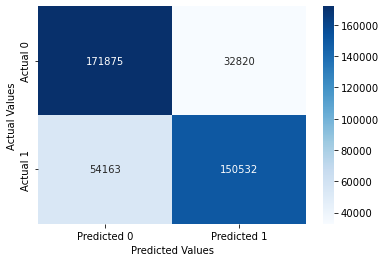

In [184]:
### Testing Confusion Matrix for BMI binning using CUT
confusion_matrix_data(train_smote, train_smote.HeartDisease, bmi_model_cut, cutoff=0.6)

Classification accuracy = 81.4%
Precision = 23.7%
TPR or Recall = 52.7%
FNR = 47.3%
FPR = 15.9%
ROC-AUC = 78.4%


171466    0.855498
43807     0.063040
73864     0.182747
72981     0.415160
280780    0.149975
            ...   
31488     0.080737
117490    0.852616
131937    0.052126
80479     0.800313
21409     0.007952
Length: 95939, dtype: float64

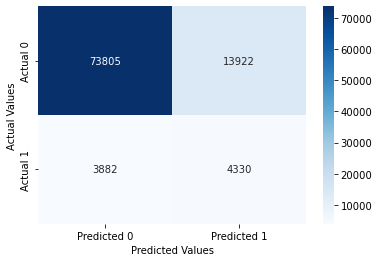

In [185]:
confusion_matrix_data(test, test.HeartDisease, bmi_model_cut, cutoff=0.6)

Classification accuracy = 78.8%
Precision = 82.1%
TPR or Recall = 73.5%
FNR = 26.5%
FPR = 16.0%
ROC-AUC = 87.6%


0         0.056772
1         0.905167
2         0.091556
3         0.500920
4         0.021819
            ...   
409385    0.977996
409386    0.833080
409387    0.780871
409388    0.817581
409389    0.941296
Length: 409390, dtype: float64

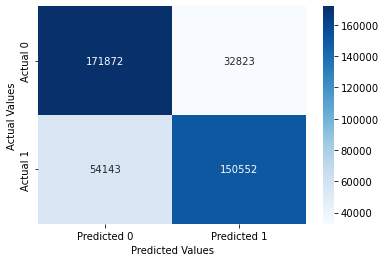

In [186]:
### Testing Confusion Matrix for BMI binning using QCUT
confusion_matrix_data(train_smote, train_smote.HeartDisease, bmi_model_qcut, cutoff=0.6)

Classification accuracy = 81.5%
Precision = 23.8%
TPR or Recall = 52.8%
FNR = 47.2%
FPR = 15.8%
ROC-AUC = 78.5%


171466    0.857348
43807     0.064005
73864     0.174717
72981     0.418469
280780    0.132066
            ...   
31488     0.080285
117490    0.851958
131937    0.053268
80479     0.797338
21409     0.006958
Length: 95939, dtype: float64

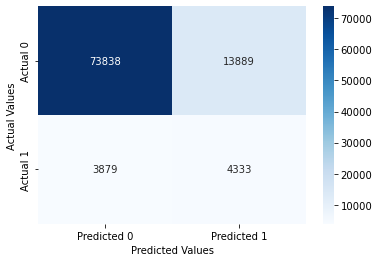

In [187]:
confusion_matrix_data(test, test.HeartDisease, bmi_model_qcut, cutoff=0.6)